# Intelligent Scale Reading

The purpose of this is to take in an image captured via iPhone camera and determine what the weight displayed on the scale is.  This will then be passed down the pipeline to record and perform analytics on.


In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

## Step 1 (Didn't work): Retrieiving Digit Images to Train on

First step is to build the data library for the model to learn the digits 0-9 and be able to identify them in photos.  We'll use the google_images_download (which we have already installed chromedriver.exe for) to retrieve our training data.

In [ ]:
from google_images_download import google_images_download as gi

In [ ]:
response = gi.googleimagesdownload()



Let's try out one digit to make sure our retrieval method is working properly. 



In [ ]:
## Pass in the various arguments here - note they will be downloaded to download folder 
# they will need to be moved to the proper training spots

arguments = {
    "keywords" : "the number six", 
    "limit" : 100, 
    "print_urls" : False, 
    "chromedriver" : "E:\\chromedriver.exe"
} 

In [ ]:
paths = response.download(arguments)
# Clear this output before printing

Now that we know that one works, we'll download the rest of the digits in the same way.

In [ ]:
digits_list = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight','nine'];
for digit in digits_list:
    arguments['keywords'] = 'the number ' + str(digit)
    paths = response.download(arguments)

Then we'll have to manually clean the data, then move it to /src/data/digits.  From there, we'll manually split up into training and test data (after we've cleaned up the wrong files as well).

### Build the validation set

In [ ]:
digits_list = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight','nine'];
for digit in digits_list:
    arguments['keywords'] = 'number ' + str(digit) + " clipart"
    paths = response.download(arguments)

## Step 1 (Attempt 2): Building a Number digit Generator

So that failed miserably - it will take way too long to download and curate all of those images.  Probably the best thing to do is build some kind of data generated that creates images with various transformations in various fonts.

List of transforms we want:
    - Massive scaling discrepancies (between 0.1 and 2.5)
    - Rotations all about - probably between 0-90
    - Brightness and contrast moved about between 0-50 %
    - Definitely want some kind of noise applied as well
    - Different background colours

Fonts we want to use:
    - Emphasis on the LED fonts
    - Can use other ones as well though
    
Number of examples we want to generate:
    - 2000 a piece

In [ ]:
import cv2

In [ ]:
img = np.zeros((512,512,3), np.uint8)

In [ ]:
font = cv2.FONT_HERSHEY_SIMPLEX
output = cv2.putText(img,'OpenCV',(10,500), font, 4,(255,255,255),2,cv2.LINE_AA)
plt.imshow(output)

In [ ]:
from PIL import ImageFont, ImageDraw, Image

In [ ]:
img = np.zeros((200,200,3),np.uint8)
b,g,r,a = 0,255,255,0
fontpath = "/src/data/digits/fonts/"
font_size=64
x_pos = 10
y_pos = 100

In [ ]:
digit = 4

 - We downloaded a bunch of LED type fonts, since that's what we'll be using for the scale
 - https://www.dafont.com/theme.php?cat=302

In [ ]:
## Use simsum.ttc to write Chinese.

font = ImageFont.truetype(fontpath + "alarm clock.ttf", font_size)
img_pil = Image.fromarray(img)
draw = ImageDraw.Draw(img_pil)
draw.text((x_pos, y_pos),  str(digit), font = font, fill = (b, g, r, a))
img = np.array(img_pil)

In [ ]:
plt.imshow(img)

In [ ]:
plt.imsave("/src/data/digits/4.jpg", img)

### Now time to make the generator

In [5]:
from PIL import ImageFont, ImageDraw, Image
img = np.zeros((200,200,3),np.uint8)
fontpath = "/src/data/digits/fonts/"


In [6]:
ttfs_array = os.listdir(fontpath); ttfs_array


['alarm clock.ttf',
 'Calculator.ttf',
 'digital-7 (italic).ttf',
 'digital-7 (mono italic).ttf',
 'digital-7 (mono).ttf',
 'digital-7.ttf',
 'DJB Get Digital.ttf',
 'Open 24 Display St.ttf',
 'Technology-Bold.ttf',
 'Technology-BoldItalic.ttf',
 'Technology-Italic.ttf',
 'Technology.ttf']

In [89]:
def rotateImage(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result


def generate_image(digit):
    '''
    Generates the image
    '''
    img = np.zeros((500,500,3),np.uint8)
    img[img == 0] = random.randint(100,240)
    font_size = random.randint(50,90)
    font = ImageFont.truetype(fontpath + ttfs_array[random.randint(0,len(ttfs_array)-1)], 
                              size=font_size)
    
    img_pil = Image.fromarray(img)
    
    draw = ImageDraw.Draw(img_pil)
    
    b = random.randint(0,100)
    g = random.randint(10,100)
    r = random.randint(10,100)
    a = 0
    
    x_pos = random.randint(100,300)
    y_pos = random.randint(100,300)
    
    draw.text((x_pos, y_pos),  str(digit), font = font, fill = (b, g, r, a))
    img = np.array(img_pil)
    img = rotateImage(img, random.randint(-60,60))
    
    return img


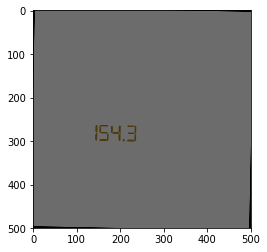

In [90]:
img = generate_image(154.3)
plt.imshow(img)

In [ ]:
'''
generated_digits = {
    "1" : "one",
    "2" : "two",
    "3" : "three",
    "4" : "four",
    "5" : "five",
    "6" : "six",
    "7" : "seven",
    "8" : "eight",
    "9" : "nine",
    "0" : "zero"
}
'''

# We have changed this function substantially, when we have changed our approach

def generate_images(save_path, total_number):
    for digit in generated_digits.keys():
        count = 0
        for i in range(0,total_number):
            img = generate_image(digit)
            #plt.imsave(save_path + generated_digits[digit] + "/" + str(count) + ".jpg", img)
            # Since this is multiclass, I'm going to try and put them all in the same directory
            #, then generate a csv
            plt.imsave(save_path + generated_digits[digit] + "_" + str(count) + ".jpg", img)
            
            count += 1
        print ("Finished with " + str(digit))



In [ ]:
save_path = "/src/data/digits/test/"
total_number = 500
generate_images(save_path, total_number)

save_path = "/src/data/digits/train/"
total_number = 2000
generate_images(save_path, total_number)

### Now to create the csv


In [ ]:
generated_digits

In [ ]:
labels_csv = "id,type"
for i in generated_digits.keys():
    digited = generated_digits[i]
    print (digited)
    for j in range(0,total_number):
        if(digited != None):
            labels_csv += ("\r\n" + digited + "_" + str(j) + "," + digited)


In [ ]:
labels_csv
f = open("/src/data/digits/labels.csv", "w")
f.write(labels_csv)

## [In Progress] Step 2: Building the Model

We'll be using the resnet 18, with a batch size of 64 (at least at first - this can definitely change).  

In [37]:
PATH = "/src/data/digits/"

arch = resnet34
bs = 64
sz = 200

import os
os.listdir(PATH)


['fonts', 'labels.csv', 'models', 'photo.jpg', 'test', 'tmp', 'train']

In [ ]:
label_csv = f'{PATH}labels.csv'
label_len = len(list(open(label_csv))) - 1 # header is not counted (-1)
val_idxs = get_cv_idxs(20000) # random 20% data for validation set

In [ ]:
label_len

In [ ]:
val_idxs

In [ ]:
m = arch(True) # True allows precompute, false disallows

In [ ]:
m

Let's convert this arch and add a few layers at the end

In [ ]:
#m = nn.Sequential(*children(m)[:-2], 
#                  nn.Conv2d(512, 10, 3, padding=1), 
#                  #nn.AdaptiveAvgPool2d(1), Flatten(), # I am actually an idiot
#                  nn.LogSoftmax())

These are the ones added:
    ```(8): Conv2d(512, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  <---- I HAVE 10 DIGITS   
  (11): LogSoftmax()
```

In [ ]:
label_df = pd.read_csv(label_csv)

In [ ]:
label_df.head()

In [ ]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
#data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test',
                                       val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)

In [ ]:
#learn = ConvLearner.from_model_data(m, data)
learn = ConvLearner.pretrained(arch, data, precompute=True
                              )

In [ ]:
#learn.freeze_to(-4) # Tried to only unfreeze 4, didn't seem to work - huge losses
#learn.unfreeze()

In [ ]:
learn.fit(0.01, 1)

In [ ]:
learn.lr_find()

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.sched.plot()

In [ ]:
learn.fit(0.07, 5)

In [ ]:
learn.fit(0.03, 5, cycle_len=2)

In [ ]:
learn.fit(0.025, 15, cycle_len=2)

In [ ]:
learn.fit(0.03, 15, cycle_len=2)

In [ ]:
learn.freeze_to(-8)

In [ ]:
learn.lr_find()

In [ ]:
learn.sched.plot()

In [ ]:
learn.fit(0.07,10)

In [ ]:
learn.fit(0.05,10, cycle_len=2)

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit([0.2,0.1,0.07],40)

In [ ]:
learn.fit([0.1,0.05,0.01],40)

In [ ]:
learn.save("scale_80")

In [ ]:
learn.load("scale_80")

In [ ]:
learn.fit([0.1,0.05,0.01],40)

In [ ]:
learn.save("scale_85")

In [ ]:
learn.load("scale_85")

## Step 3: Determining the Locations of the matches (so as to give order)

This is the heatmap (probably more of a bounding box)

Other thoughts - we'll want to count the number of occurrences.  If the photo given doesn't have enough matches, then we want to return an error

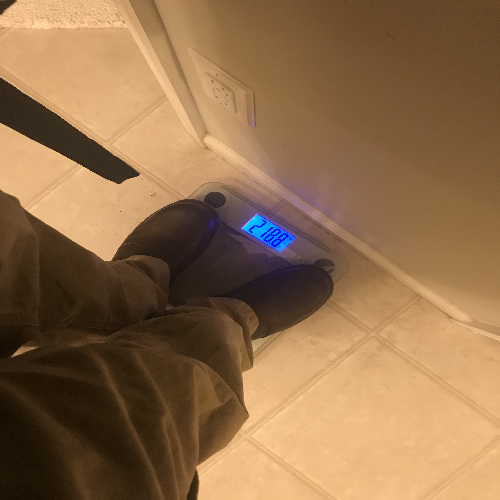

In [38]:

Image.open(PATH + "photo.jpg").resize((500, 500))

In [ ]:
im = open_image(PATH + "photo.jpg")

In [ ]:
im

In [ ]:
learn.predict_array(im[None])

In [ ]:
trn_tfms, val_tfms = tfms_from_model(arch, sz)
im = val_tfms(open_image(PATH + "photo.jpg")) # open_image() returns numpy.ndarray
preds = learn.predict_array(im[None])

In [ ]:
preds

In [ ]:
learn.data.classes

In [ ]:
np.argmax(preds)

In [ ]:
learn.data.classes[7]